In [3]:
import pandas as pd
import requests
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

In [4]:
event_url = 'https://api.fda.gov/drug/event.json?'
key = "i7P1mwCHejloX1YuqY4wt5jOlt8tzsuSXEzJP9Ti"

### Serious events over time

1 = The adverse event resulted in death, a life threatening condition, hospitalization, disability, congenital anomali, or other serious condition.

2 = The adverse event did not result in any of the above.

In [5]:
parameters = 'search=receivedate:[20040101+TO+20150101]+AND+serious:1&count=receivedate'
query = event_url + "api_key=" + key + "&" + parameters
r = requests.get(query)
serious1_df = pd.DataFrame(r.json()['results'])
serious1_df.set_index('time', inplace=True)
serious1_df.columns = ['serious1']
serious1_df.index = pd.to_datetime(serious1_df.index)

parameters = 'search=receivedate:[20040101+TO+20150101]+AND+serious:2&count=receivedate'
query = event_url + "api_key=" + key + "&" + parameters
r = requests.get(query)
serious2_df = pd.DataFrame(r.json()['results'])
serious2_df.set_index('time', inplace=True)
serious2_df.columns = ['serious2']
serious2_df.index = pd.to_datetime(serious2_df.index)

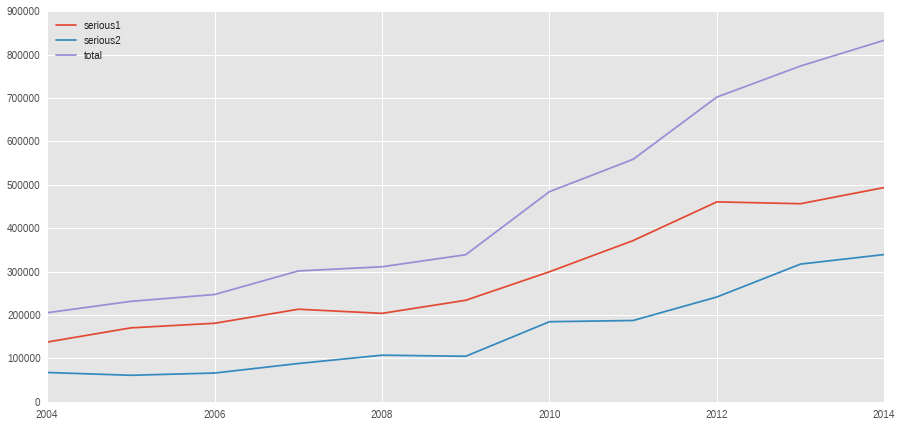

In [6]:
cum_df = pd.concat([serious1_df, serious2_df], axis=1)
cum_df['total'] = cum_df.sum(axis=1)
cum_df.groupby([cum_df.index.year]).sum().plot(figsize=(15,7))

### Male vs Female

    0 = Unknown
    1 = Male
    2 = Female

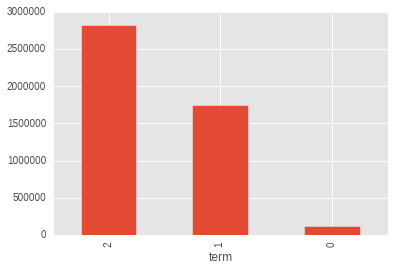

In [7]:
parameters = 'search=receivedate:[20040101+TO+20150101]&count=patient.patientsex'
query = event_url + "api_key=" + key + "&" + parameters
r = requests.get(query)

df = pd.io.json.json_normalize(r.json()['results'])
df.plot('term', 'count', kind='bar', legend=False)

### Broken down by drug classes

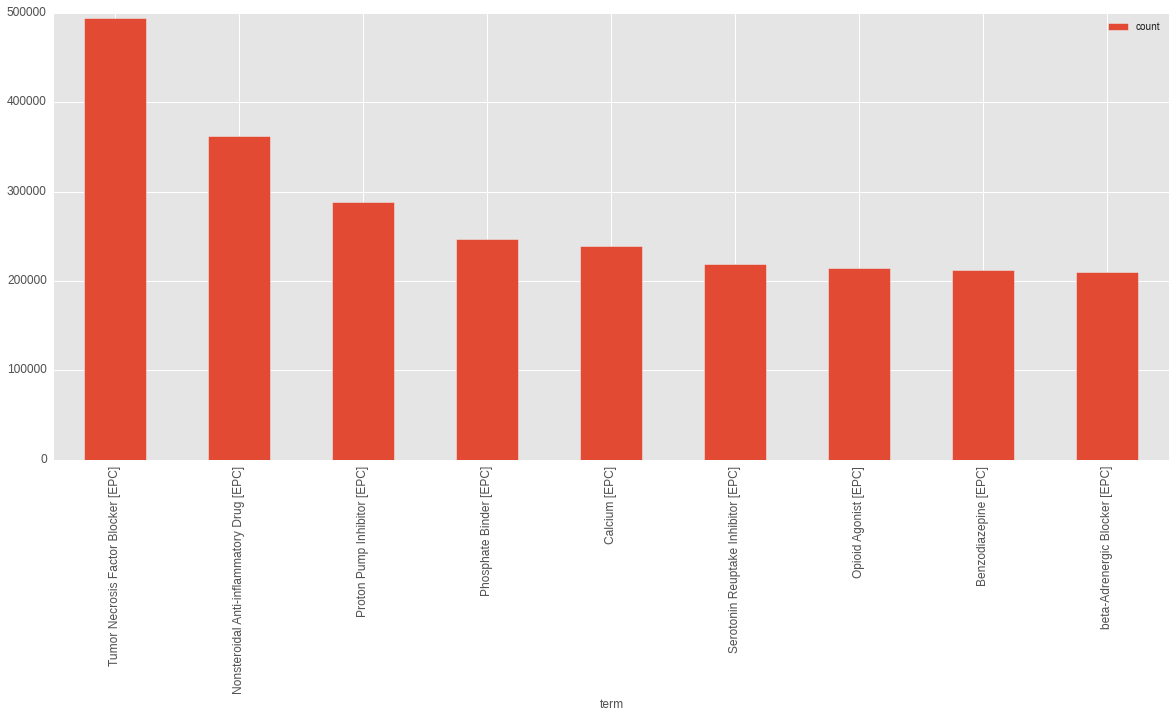

In [8]:
parameters = 'search=receivedate:[20040101+TO+20150101]&count=patient.drug.openfda.pharm_class_epc.exact'
query = event_url + "api_key=" + key + "&" + parameters

r = requests.get(query)

df = pd.io.json.json_normalize(r.json()['results'])
df[0:9].plot('term', 'count', kind='bar', figsize=(20, 8))
plt.tick_params(labelsize=12)


In [9]:
parameters = 'search=receivedate:[20040101+TO+20150101]&count=patient.drug.openfda.pharm_class_epc.exact'
query = event_url + "api_key=" + key + "&" + parameters

r = requests.get(query)
top_5 = [item['term'] for item in r.json()['results'][0:5]]

df_list = []

for drug_class in top_5: 
    parameters = 'search=receivedate:[20040101+TO+20150101]+AND+patient.drug.openfda.pharm_class_epc.exact:"%s"&count=receivedate' %drug_class
    query = event_url + "api_key=" + key + "&" + parameters

    r = requests.get(query)
    df = pd.DataFrame(r.json()['results'])
    df.set_index('time', inplace=True)
    df.columns = [drug_class]
    df.index = pd.to_datetime(df.index)
    
    df_list.append(df)

cum_df = pd.concat(df_list, axis=1)
cum_df.head()

,Tumor Necrosis Factor Blocker [EPC],Nonsteroidal Anti-inflammatory Drug [EPC],Proton Pump Inhibitor [EPC],Phosphate Binder [EPC],Calcium [EPC]
2004-01-02,22,44,29,18,18
2004-01-04,3,4,5,1,1
2004-01-05,4,24,15,4,4
2004-01-06,17,46,25,19,19
2004-01-07,6,21,22,10,10


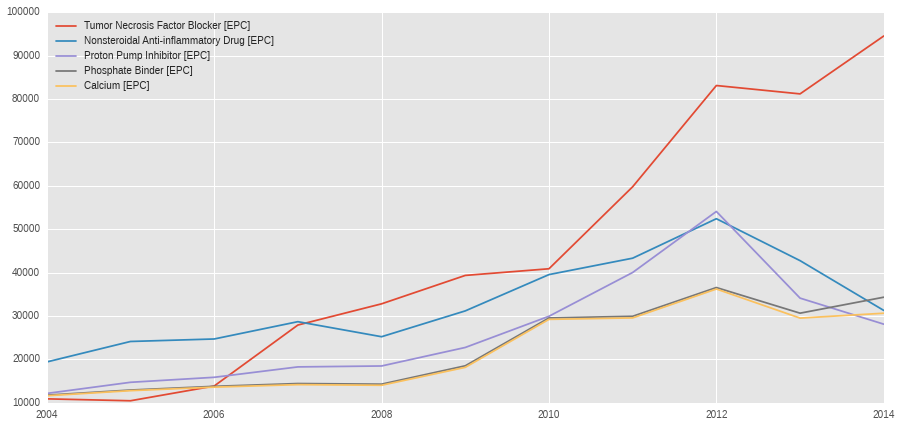

In [10]:
cum_df.groupby([cum_df.index.year]).sum().plot(figsize=(15,7))

### Broken down by administration route

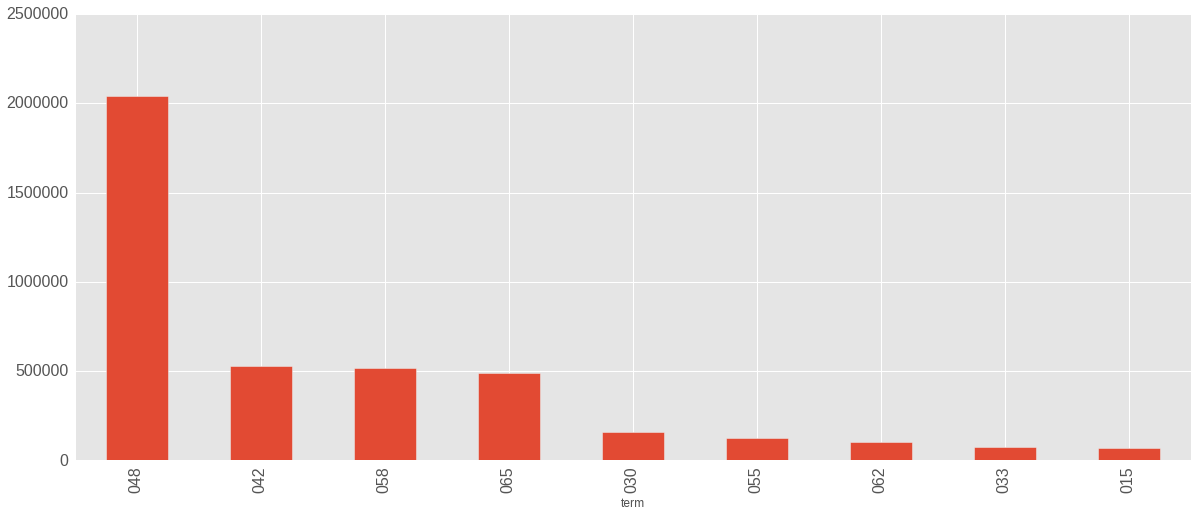

In [11]:
parameters = 'search=receivedate:[20040101+TO+20150101]&count=patient.drug.drugadministrationroute.exact'
query = event_url + "api_key=" + key + "&" + parameters

r = requests.get(query)

df = pd.io.json.json_normalize(r.json()['results'])
df[0:9].plot('term', 'count', kind='bar', figsize=(20, 8), legend=False)
plt.tick_params(labelsize=16)

### NSAIDs

    The unit for patient.drug.drugtreatmentduration
    801 = Year
    802 = Month
    803 = Week
    804 = Day
    805 = Hour
    806 = Minute

In [73]:
parameters = ('search=receivedate:[20040101+TO+20150101]'+
              '+AND+patient.drug.openfda.pharm_class_epc.exact:"Nonsteroidal Anti-inflammatory Drug [EPC]"'+
              '+AND+patient.drug.drugtreatmentdurationunit:804'
              '&count=patient.drug.drugtreatmentduration')
query = event_url + "api_key=" + key + "&" + parameters

r = requests.get(query)
df = pd.DataFrame(r.json()['results'])

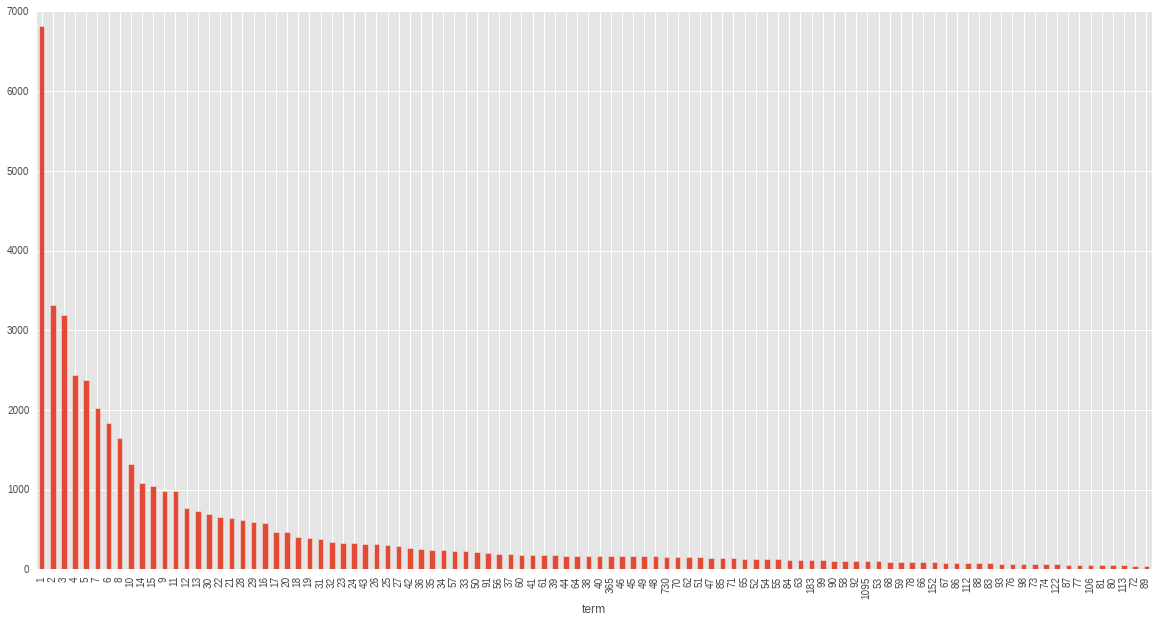

In [84]:
df.set_index('term').plot(kind='bar', figsize=(20,10), legend=False)

### Neuro-drugs

In [13]:
parameters = 'search=receivedate:[20040101+TO+20150101]&count=patient.drug.openfda.pharm_class_epc.exact'
query = event_url + "api_key=" + key + "&" + parameters

r = requests.get(query)
all_classes = [item['term'] for item in r.json()['results']]

In [14]:
neuro_substr = ['mood', 'dopamine', 'psych', 'anxi', 'depress', 'benzo', 'epil', 'seroton', 'aminobutyric', 'gaba']
neuro_list = [drug_class for drug_class in all_classes for substr in neuro_substr if substr in drug_class.lower()]
#grabs a serotonergic drug used for anti-nauseau with chemo therapy, so dropping it
del neuro_list[-1]
neuro_list

[u'Serotonin Reuptake Inhibitor [EPC]',
 u'Benzodiazepine [EPC]',
 u'Anti-epileptic Agent [EPC]',
 u'Atypical Antipsychotic [EPC]',
 u'Serotonin and Norepinephrine Reuptake Inhibitor [EPC]',
 u'Mood Stabilizer [EPC]',
 u'gamma-Aminobutyric Acid-ergic Agonist [EPC]',
 u'Dopamine-2 Receptor Antagonist [EPC]']

In [15]:
df_list = []
for drug in neuro_list: 
    parameters = 'search=receivedate:[20040101+TO+20150101]+AND+patient.drug.openfda.pharm_class_epc.exact:"%s"&count=receivedate' %drug
    query = event_url + "api_key=" + key + "&" + parameters

    r = requests.get(query)
    df = pd.DataFrame(r.json()['results'])
    df.set_index('time', inplace=True)
    df.columns = [drug]
    df.index = pd.to_datetime(df.index)
    
    df_list.append(df)

In [17]:
cum_df = pd.concat(df_list, axis=1)
cum_df.head()

,Serotonin Reuptake Inhibitor [EPC],Benzodiazepine [EPC],Anti-epileptic Agent [EPC],Atypical Antipsychotic [EPC],Serotonin and Norepinephrine Reuptake Inhibitor [EPC],Mood Stabilizer [EPC],gamma-Aminobutyric Acid-ergic Agonist [EPC],Dopamine-2 Receptor Antagonist [EPC]
2004-01-02,43,32,30,30,8,16,7,3
2004-01-04,8,4,2,4,1,NaN,NaN,NaN
2004-01-05,11,16,11,8,1,8,5,NaN
2004-01-06,26,33,24,13,2,5,5,2
2004-01-07,13,19,19,12,4,6,4,4


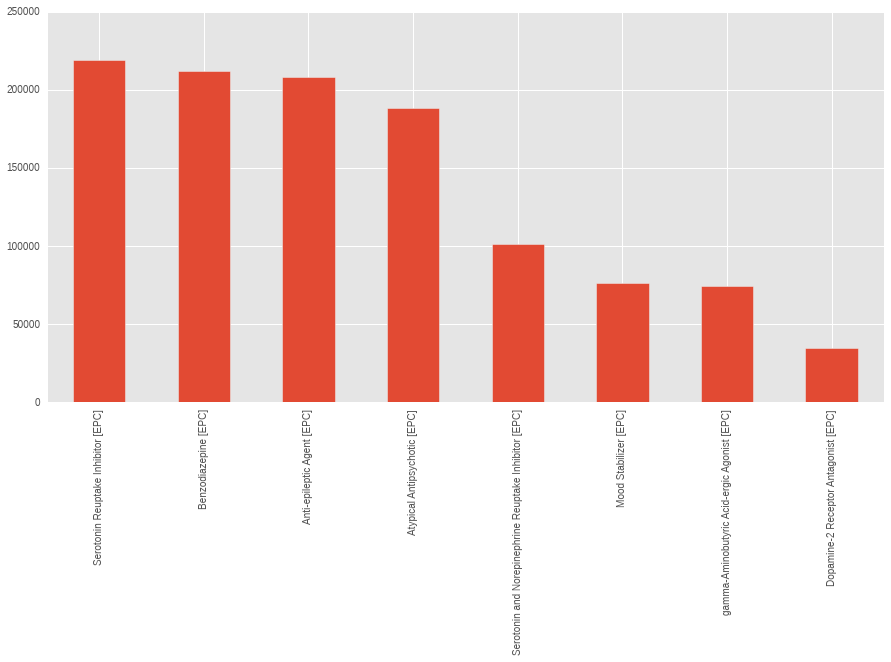

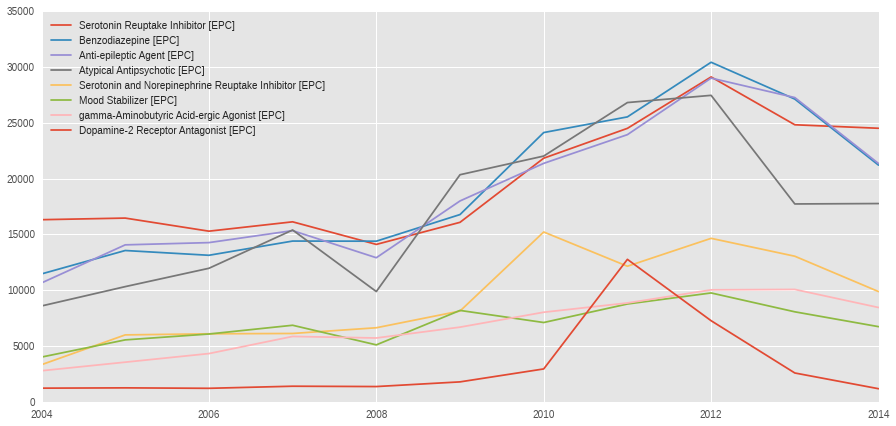

In [26]:
cum_df.sum().plot(kind="bar", figsize=(15,7))
cum_df.groupby([cum_df.index.year]).sum().plot(figsize=(15,7))

([<matplotlib.axis.XTick at 0x7f1850d098d0>,
 <a list of 2 Text xticklabel objects>)

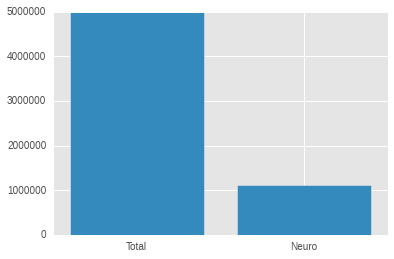

In [49]:
parameters = 'search=receivedate:[20040101+TO+20150101]&count=receivedate'
query = event_url + "api_key=" + key + "&" + parameters

r = requests.get(query)
df = pd.DataFrame(r.json()['results'])
total_events = df.sum()
total_neuro = cum_df.sum().sum()
plt.bar([1,2], [total_events['count'], total_neuro], align='center')
plt.xticks([1,2], ['Total', 'Neuro'])

In [89]:
df_list = []
for drug in neuro_list: 
    parameters = ('search=receivedate:[20040101+TO+20150101]'+
                  '+AND+patient.drug.openfda.pharm_class_epc.exact:"%s"' %drug+
                  '+AND+patient.drug.drugtreatmentdurationunit:804'
                  '&count=patient.drug.drugtreatmentduration')
    query = event_url + "api_key=" + key + "&" + parameters
    
    r = requests.get(query)
    df = pd.DataFrame(r.json()['results'])
    df.set_index('term', inplace=True)
    df.columns = [drug]
    
    df_list.append(df)

cum_df = pd.concat(df_list, axis=1)
cum_df.head()

,Serotonin Reuptake Inhibitor [EPC],Benzodiazepine [EPC],Anti-epileptic Agent [EPC],Atypical Antipsychotic [EPC],Serotonin and Norepinephrine Reuptake Inhibitor [EPC],Mood Stabilizer [EPC],gamma-Aminobutyric Acid-ergic Agonist [EPC],Dopamine-2 Receptor Antagonist [EPC]
1,2541,4428,2540,1998,1339,1079,1245,826
10,592,841,598,505,236,303,254,155
100,NaN,NaN,NaN,22,NaN,NaN,NaN,NaN
105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
106,38,28,32,24,NaN,15,NaN,NaN


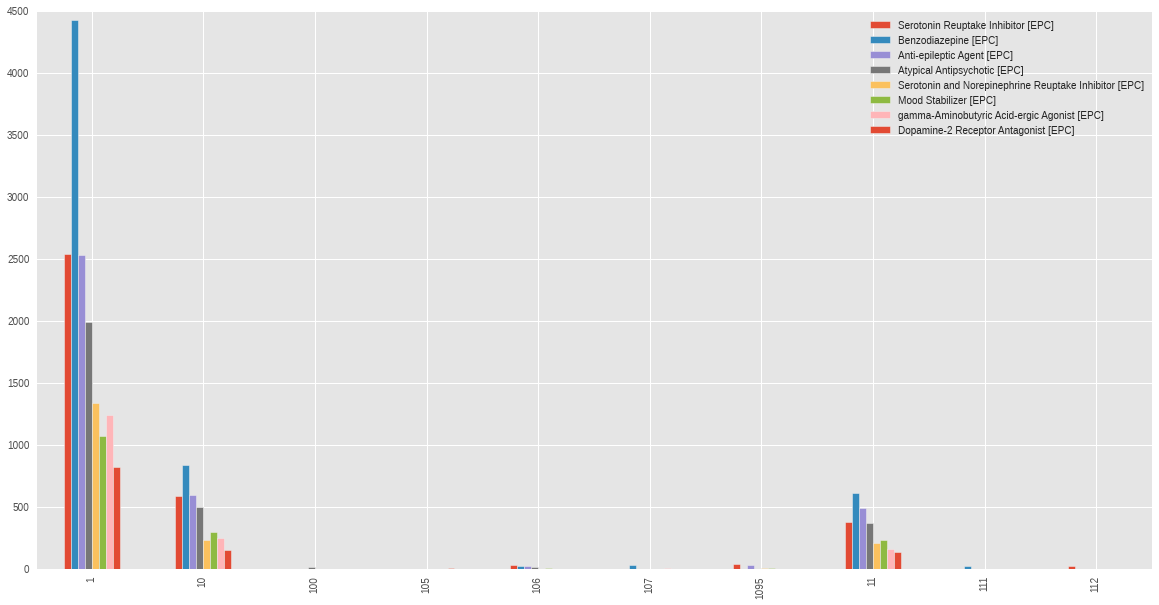

In [93]:
cum_df.sort().head(10).plot(kind='bar', figsize=(20,10))